In [1]:
# Change directory to the parent directory
import os
os.path.abspath(os.curdir)
os.chdir("..")
os.getcwd()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from source import *

from scipy.optimize import minimize

# Data Processing

In [2]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('./data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('./data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('./data/natgas_futures_price.csv', sep=',')

In [3]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%Y-%m-%d')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1991-01-03,1.782,-2.767194,1991-01,101.211242,13
1991-01-04,1.743,-2.212856,1991-01,101.211242,13
1991-01-07,1.785,2.381065,1991-01,101.211242,13
1991-01-08,1.786,0.056007,1991-01,101.211242,13
1991-01-09,1.728,-3.301381,1991-01,101.211242,13


# Exploratory Data Analysis

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\plot.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Monthly_Disaster_Freq'].resample('M').mean().plot(ax=ax2)
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\plot.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['cpu_index'].resample('M').mean().plot(ax=ax3)


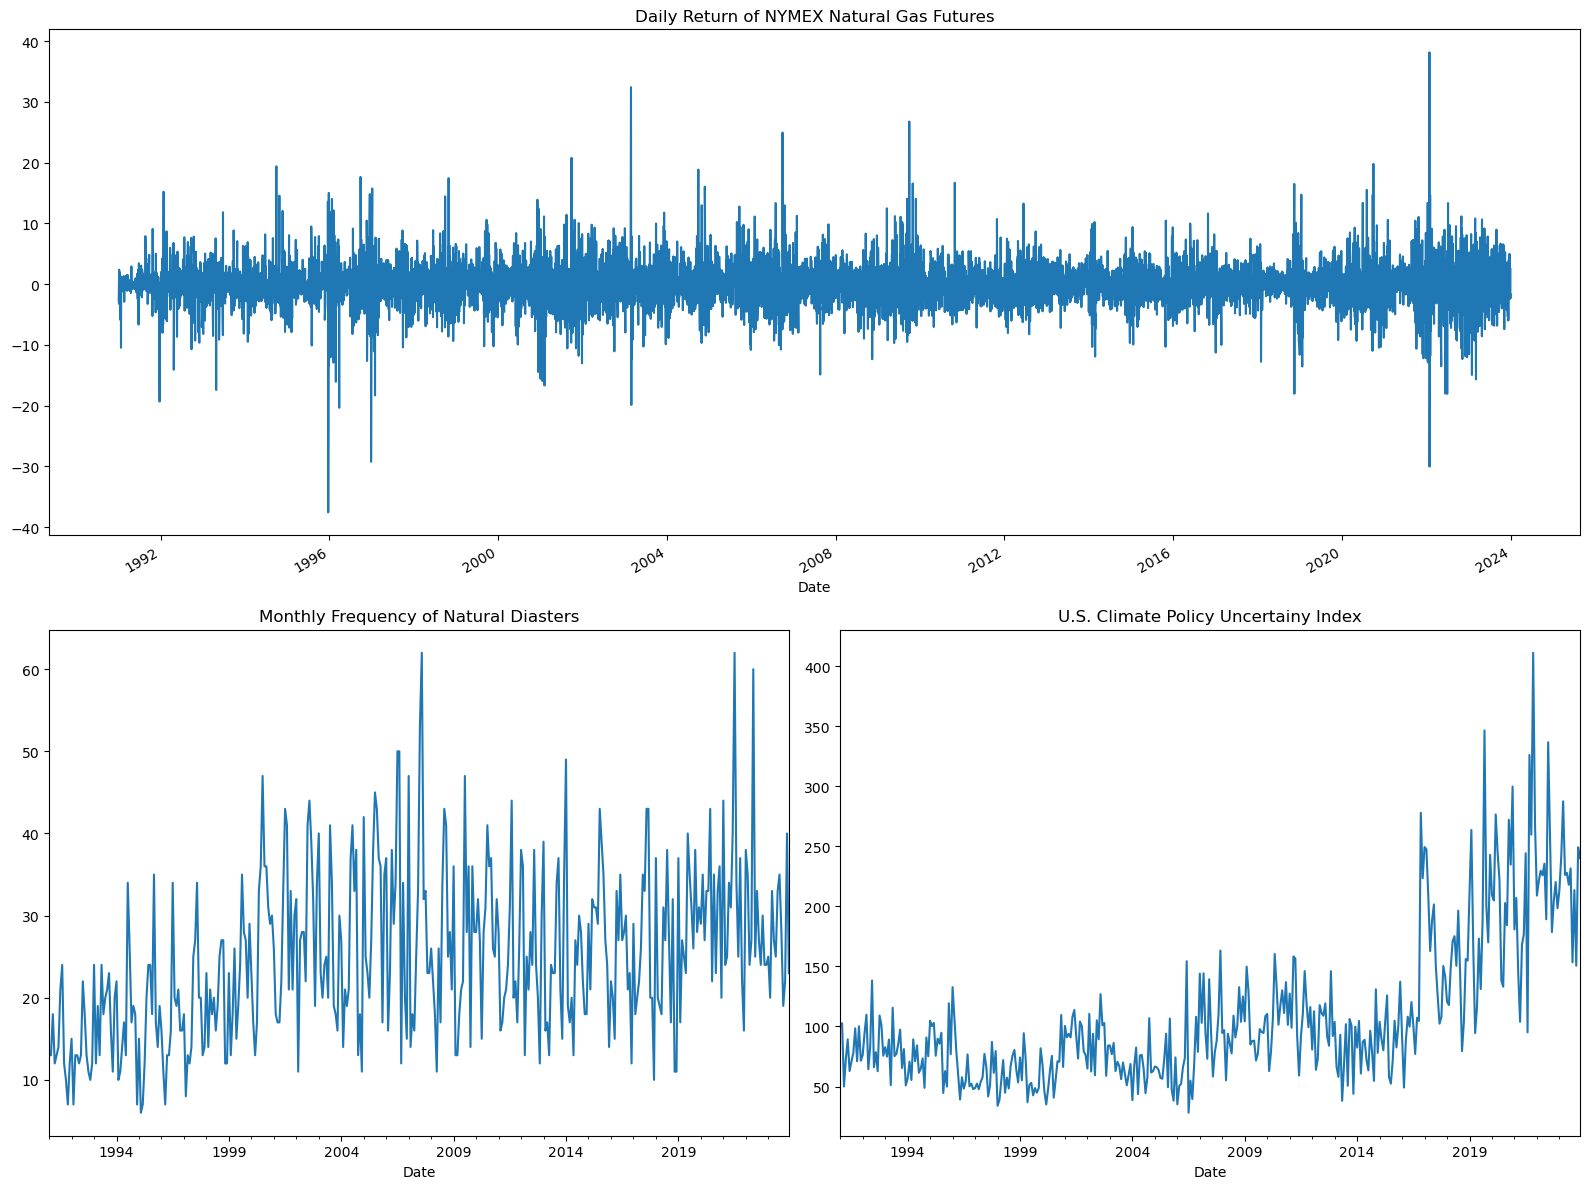

In [4]:
plot_eda(data)

In [5]:
get_descriptive_stats(data)

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\stats.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpu = np.array(df['cpu_index'].resample('M').mean())
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\stats.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  emdat = np.array(df['Monthly_Disaster_Freq'].resample('M').mean())


,Obs,mean,std,min,max,skewness,kurtosis,ADF
Data,,,,,,,,
Natural gas futures return (daily),8185,0.008689,3.605597,-37.574864,38.172676,0.083657,8.025894,-18.090219
CPU Index,396,107.506311,61.029553,28.161927,411.288806,1.635860,2.841566,-0.411548
d. ln(CPU Index),395,0.002187,0.365871,-1.701375,1.232682,-0.209925,0.823205,-8.106798
Natural disasters frequency,396,24.974747,9.958975,6.000000,62.000000,0.641825,0.373162,-2.249454
d. ln(Natural disasters frequency),395,0.001444,0.441468,-1.427116,1.339774,-0.033306,0.307224,-8.645277


In [6]:
run_kpss_test(data)

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\stats.py:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpu = np.array(df['cpu_index'].resample('M').mean())
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\stats.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  emdat = np.array(df['Monthly_Disaster_Freq'].resample('M').mean())
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\stats.py:100: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(data)
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\stats.py:100: InterpolationWarning: The test statistic is outside of the range o

,KPSS Statistic,p-value
Data,,
Natural gas futures return (daily),0.067364,0.10
CPU Index,2.205007,0.01
d. CPU Index,0.263228,0.10
d. ln(CPU Index),0.170123,0.10
Natural disasters frequency,2.000746,0.01
d. Natural disasters frequency,0.108992,0.10
d. ln(Natural disasters frequency),0.058076,0.10


# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance, lag = 36

In [7]:
# Get required split for lag = 36
X_36train, X_36test, train36_returns, test36_returns =\
    is_os_split(data, '2022-12-01', 36, diff = 'first_order')

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source

In [8]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.05, 0.09, 0.90, 1.1, 1, -2])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0], 36)) ## Limited Memory BFGS

results

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:236: RuntimeWarning: overflow encountered in scalar multiply
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:239: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:242: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.682488396895
        x: [ 5.613e-02  8.723e-02  8.995e-01  7.696e-02 -7.385e-02
            -2.008e+00]
      nit: 66
      jac: [-2.183e-03  1.499e-01  8.295e-02 -3.711e-02  5.821e-03
            -3.274e-01]
     nfev: 735
     njev: 105
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [9]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results['x'], train36_returns, X_36train[0], 36, full_output=True)
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (train36_returns, X_36train[0], 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.056126,8.723008e-02,0.899485,0.076959,-0.073853,-2.008004
p-val,0.043973,2.087646e-47,0.000000,0.000022,0.265932,0.216704


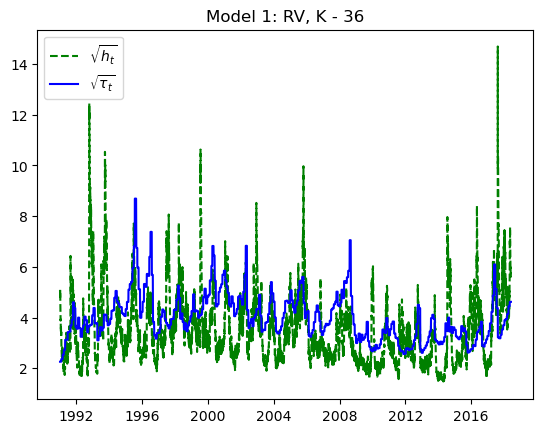

In [10]:
# Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

plot_results(date_array, ht, tau, title = 'Model 1: RV, K - 36')

---
## Two-factors GARCH-MIDAS

Model 2: RV + CPU, lag = 36

In [11]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.05, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[:2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:236: RuntimeWarning: overflow encountered in scalar multiply
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:239: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:242: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.630571423328
        x: [ 5.629e-02  8.720e-02  8.995e-01  7.662e-02  4.972e-02
            -7.517e-02  1.094e+00 -1.953e+00]
      nit: 58
      jac: [ 1.641e-01  3.965e+00  3.148e+00 -1.472e+00 -3.845e-01
            -6.221e-02 -3.009e-01 -3.329e-01]
     nfev: 756
     njev: 84
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [12]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], train36_returns, X_36train[:2], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (train36_returns, X_36train[:2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.056287,8.720415e-02,0.899497,0.076619,0.049719,-0.075168,1.093560e+00,-1.953441
p-val,0.047155,3.447547e-47,0.000000,0.000014,0.424297,0.288362,4.696271e-07,0.217070


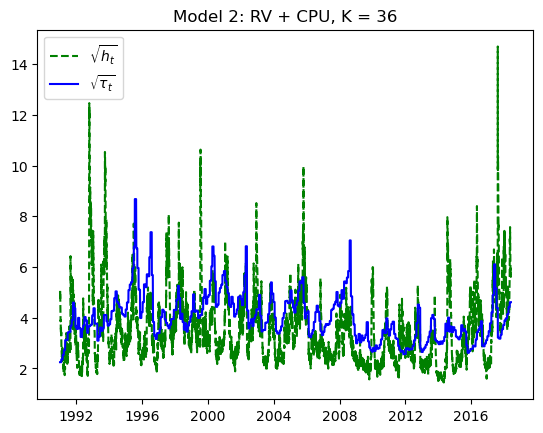

In [13]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 2: RV + CPU, K = 36')

Model 3: RV + EMDAT, K = 36

In [14]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[::2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:236: RuntimeWarning: overflow encountered in scalar multiply
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:239: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:242: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18556.014647423974
        x: [ 5.851e-02  8.503e-02  9.008e-01  7.182e-02  2.051e+00
            -1.110e-01  1.972e+00 -1.618e+00]
      nit: 55
      jac: [ 1.248e-01  2.950e-01  6.825e-01  1.197e+00 -3.100e-01
             1.244e-01  7.232e-01 -2.583e-01]
     nfev: 702
     njev: 78
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [15]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], train36_returns, X_36train[::2], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (train36_returns, X_36train[::2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.058507,8.502764e-02,0.900795,0.071824,2.051044,-0.111036,1.972346,-1.617963
p-val,0.038776,1.769246e-43,0.000000,0.000033,0.288276,0.194057,0.263350,0.253033


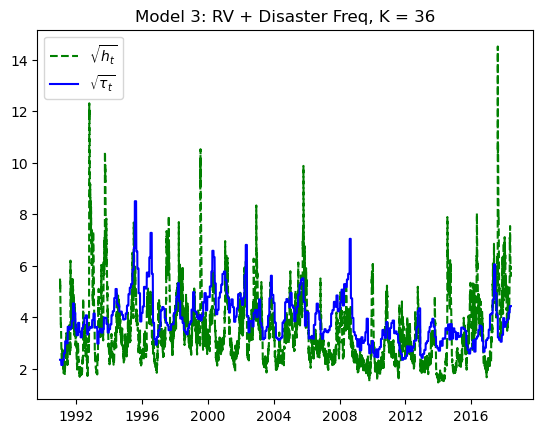

In [16]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 3: RV + Disaster Freq, K = 36')

---
## Three-Factors GARCH-MIDAS
Model 4: RV + CPU + EMDAT, K = 36

In [17]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, X_36train, 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results4

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:236: RuntimeWarning: overflow encountered in scalar multiply
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:239: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:242: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18555.85343115354
        x: [ 5.833e-02  8.493e-02  9.009e-01  7.194e-02  1.580e-01
             1.946e+00 -1.051e-01  1.613e+00  2.063e+00 -1.657e+00]
      nit: 72
      jac: [ 4.802e-02 -8.331e-01 -1.003e+00 -7.858e-02 -1.601e-01
            -3.216e-01 -3.929e-02 -9.713e-02  7.152e-01 -2.889e-01]
     nfev: 1089
     njev: 99
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [18]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], train36_returns, X_36train, 36, get_tau=get_threefactor_tau, full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (train36_returns, X_36train, 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.058333,8.492510e-02,0.9009,0.071939,0.157970,1.945626e+00,-0.105091,1.612852,2.063459e+00,-1.657131
p-val,0.039219,3.999038e-46,0.0000,0.000003,0.258526,9.854751e-08,0.202319,0.073962,1.493977e-09,0.231903


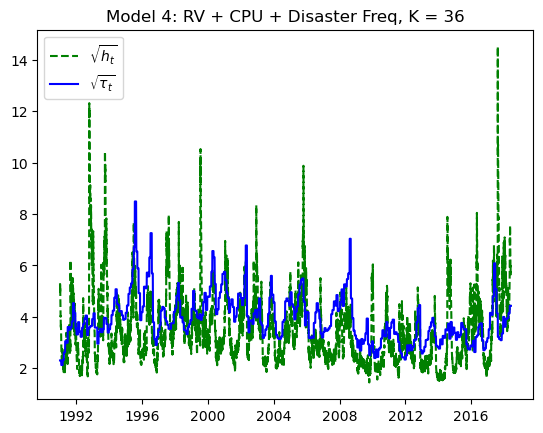

In [19]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 4: RV + CPU + Disaster Freq, K = 36')

Model 5: RV + CPU + EMDAT, K = 33

In [20]:
# Get required split for lag = 33
X_33train, X_33test, train33_returns, test33_returns =\
    is_os_split(data, '2022-12-01', 33, diff = 'first_order')

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source

In [21]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train33_returns, X_33train, 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results5

c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:236: RuntimeWarning: overflow encountered in scalar multiply
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:239: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()
c:\Users\leeca\OneDrive\Documents\All Finance Topics\SMU MQF\QF604_Econometrics\qf604\source\garchmidas.py:242: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18729.031094528516
        x: [ 5.009e-02  8.984e-02  8.924e-01  3.046e-02  2.782e-01
             3.926e+00  4.575e-02  2.447e+00  9.368e-01  5.987e+00]
      nit: 198
      jac: [-8.004e-02 -3.893e-01 -2.234e-01 -6.337e-01  3.929e-02
            -4.002e-03  5.348e-02 -2.765e-02  1.208e-01  7.276e-04]
     nfev: 2585
     njev: 235
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [22]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], 
                                                  train33_returns, X_33train, 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results5['x'], 
              (train33_returns, X_33train, 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.050089,8.983689e-02,0.892424,0.030457,0.278242,3.925720,0.045752,2.447323,9.368086e-01,5.987255
p-val,0.064588,7.116301e-47,0.000000,0.001107,0.159756,0.000017,0.426962,0.133904,3.120351e-21,0.003646


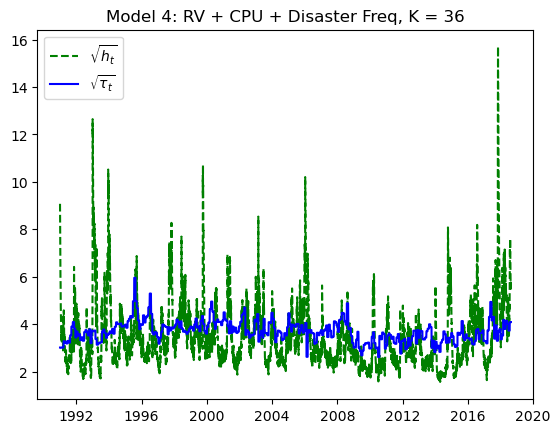

In [23]:
date_array33 = pd.date_range(start=start_date, periods=T, freq='B')

# Plot 
plot_results(date_array33, ht, tau, title = 'Model 4: RV + CPU + Disaster Freq, K = 36')

---
## Out-sample Analysis

$$L_{MSE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}(\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}})^2$$

$$L_{MAE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}|\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}}|$$

In [24]:
df_realized_vol = pd.read_csv('./data/intraday_realized_volatility.csv', 
                              encoding_errors='ignore')

df_realized_vol.set_index('Date', inplace = True)
df_realized_vol.index = pd.to_datetime(df_realized_vol.index)

realized_vol = np.array(df_realized_vol.loc[df_realized_vol.index >= '2022-12-01', 'Volatility'])

In [25]:
LMSE1, LMAE1 = out_sample_test(test36_returns, realized_vol, X_36test[0], 36, results, [10,30,60,90,118])
LMSE2, LMAE2 = out_sample_test(test36_returns, realized_vol, X_36test[:2], 36, results2, [10,30,60,90,118])
LMSE3, LMAE3 = out_sample_test(test36_returns, realized_vol, X_36test[::2], 36, results3, [10,30,60,90,118])
LMSE4, LMAE4 = out_sample_test(test36_returns, realized_vol, X_36test, 36, results4, [10,30,60,90,118])
LMSE5, LMAE5 = out_sample_test(test33_returns, realized_vol, X_33test, 33, results5, [10,30,60,90,118])

In [26]:
pd.DataFrame({
    'MSE (RV, K = 36)' : LMSE1,
    'MAE (RV, K = 36)' : LMAE1,
    'MSE (RV + CPU, K = 36)' : LMSE2,
    'MAE (RV + CPU,, K = 36)' : LMAE2,
    'MSE (RV + EMDAT, K = 36)' : LMSE3,
    'MAE (RV + EMDAT, K = 36)' : LMAE3,
    'MSE (RV + CPU + EMDAT, K = 36)' : LMSE4,
    'MAE (RV + CPU + EMDAT, K = 36)' : LMAE4,
    'MSE (RV + CPU + EMDAT, K = 33)' : LMSE5,
    'MAE (RV + CPU + EMDAT, K = 33)' : LMAE5,
}, index = ['10 days forecast','30 days forecast','60 days forecast','90 days forecast', '118 days forecast']).T

,10 days forecast,30 days forecast,60 days forecast,90 days forecast,118 days forecast
"MSE (RV, K = 36)",0.016098,0.007053,0.003664,0.002464,0.001896
"MAE (RV, K = 36)",0.124196,0.071556,0.042898,0.030888,0.025224
"MSE (RV + CPU, K = 36)",0.015856,0.006947,0.003611,0.002429,0.001869
"MAE (RV + CPU,, K = 36)",0.123251,0.071019,0.042620,0.030698,0.025078
"MSE (RV + EMDAT, K = 36)",0.011583,0.005081,0.002661,0.001796,0.001386
"MAE (RV + EMDAT, K = 36)",0.105252,0.060597,0.036873,0.026920,0.022155
"MSE (RV + CPU + EMDAT, K = 36)",0.011463,0.005033,0.002639,0.001782,0.001375
"MAE (RV + CPU + EMDAT, K = 36)",0.104702,0.060367,0.036812,0.026903,0.022144
"MSE (RV + CPU + EMDAT, K = 33)",0.011137,0.004623,0.002378,0.001601,0.001236
"MAE (RV + CPU + EMDAT, K = 33)",0.102800,0.054833,0.031956,0.023125,0.019268


In [27]:
MCS_MSE_10, MCS_MAE_10 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],10)
MCS_MSE_30, MCS_MAE_30 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],30)
MCS_MSE_60, MCS_MAE_60 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],60)
MCS_MSE_90, MCS_MAE_90 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],90)
MCS_MSE_118, MCS_MAE_118 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],118)

Bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 52620.21it/s]
c:\Users\leeca\anaconda3\envs\qf604\Lib\site-packages\model_confidence_set\core.py:191: RuntimeWarning: invalid value encountered in divide
  z0 = (dij_bar_boot - dij_bar) / dij_std
c:\Users\leeca\anaconda3\envs\qf604\Lib\site-packages\model_confidence_set\core.py:192: RuntimeWarning: divide by zero encountered in divide
  z0_data = dij_bar / dij_std
Computing MCS: 100%|██████████| 4/4 [00:00<00:00, 1971.24model/s]


In [28]:
MCS10 = pd.merge(MCS_MSE_10.sort_index()[['pvalues']],MCS_MAE_10.sort_index()[['pvalues']], on = 'models',how='inner')
MCS30 = pd.merge(MCS_MSE_30.sort_index()[['pvalues']],MCS_MAE_30.sort_index()[['pvalues']], on = 'models',how='inner')
MCS60 = pd.merge(MCS_MSE_60.sort_index()[['pvalues']],MCS_MAE_60.sort_index()[['pvalues']], on = 'models',how='inner')
MCS90 = pd.merge(MCS_MSE_90.sort_index()[['pvalues']],MCS_MAE_90.sort_index()[['pvalues']], on = 'models',how='inner')
MCS118 = pd.merge(MCS_MSE_118.sort_index()[['pvalues']],MCS_MAE_118.sort_index()[['pvalues']], on = 'models',how='inner')

In [29]:
merged_mcs = pd.concat([MCS10, MCS30,MCS60,MCS90,MCS118], keys=['10 days', '30 days', '60 days', '90 days', '120 days'])
merged_mcs = merged_mcs.rename(columns={'pvalues_x' : 'MCS_mae', 'pvalues_y' : 'MCS_mse'})
new_index_values = ['RV (K=36)', 'RV+CPU (K=36)', 'RV+EMDAT (K=36)', 'RV+CPU+EMDAT (K=36)','RV+CPU+EMDAT (K=33)']  # New values for the second level index
merged_mcs.index = merged_mcs.index.set_levels(new_index_values, level=1)
merged_mcs

MCS_mae  MCS_mse
         models                               
10 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
30 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
60 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
90 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
120 days RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0